# Fine Tune CLIP on Tweets

- CLIP on huggingface: https://huggingface.co/openai/clip-vit-base-patch32
- Dataset: https://huggingface.co/datasets/AlekseyDorkin/extended_tweet_emojis/tree/main

## 1. Install Dependencies

In [ ]:
# you might want to restart the kernel
# coupling between torch and torchvision: https://pypi.org/project/torchvision/
!pip install torchvision==0.11.1 torch==1.10.0 --quiet

In [ ]:
# you might want to restart the kernel after installation is complete.
!pip install transformers datasets pillow ipywidgets requests jupyter jupyter_client wandb --upgrade --quiet

## 2. Init Variables and Tools

In [ ]:
pwd = !pwd
data_path = pwd[0] + "/emojis"
data_path

In [ ]:
import wandb
from transformers import TrainingArguments, Trainer

wandb.init(project="emoji-predictor", entity="drift-ai")

## 3. Setup Data Preprocessors and Trainer

In [1]:
import torch
from torchvision.transforms import Resize, InterpolationMode, ConvertImageDtype, CenterCrop
from transformers import CLIPProcessor, CLIPModel, Trainer
from transformers import default_data_collator, TrainingArguments
from datasets import load_dataset
from torchvision.io import read_image, ImageReadMode
from pathlib import Path

# Loading Data
dataset = load_dataset("AlekseyDorkin/extended_tweet_emojis")
train_dataset_full = dataset["train"]
SEED = 42 # use the same seed as in step 01
TEST_SIZE = 0.1 # use the same as in step 01
train_test_dataset = train_dataset_full.train_test_split(test_size=TEST_SIZE, seed=SEED)
test_dataset = train_test_dataset["test"]
train_dataset = train_test_dataset["test"]
eval_dataset = dataset["validation"]
column_names = train_dataset.column_names
assert "label" in column_names
assert "text" in column_names
image_column = "label"
caption_column = "text"


Using custom data configuration AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0
Reusing dataset parquet (/root/.cache/huggingface/datasets/AlekseyDorkin___parquet/AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/AlekseyDorkin___parquet/AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8/cache-40036b762878c645.arrow and /root/.cache/huggingface/datasets/AlekseyDorkin___parquet/AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8/cache-907f565d049ab5a6.arrow


Text(0.5, 0, 'emojis train datatset')

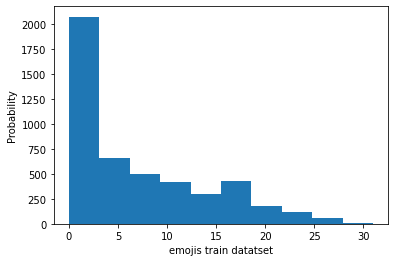

In [2]:
import matplotlib.pyplot as plt
plt.hist(train_dataset["label"])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('emojis train datatset')

In [3]:
!pip install imblearn

In [10]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
sampling_strategy = {i:250 for i in set(train_dataset["label"])}
oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
text_over, label_over = oversample.fit(X=pd.DataFrame(train_dataset["text"]), y=train_dataset["label"])

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 922 samples and 250 samples are asked.

In [ ]:

# Loading Model and Processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
config = model.config
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = processor.tokenizer
feature_extractor = processor.feature_extractor

MAX_TEXT_LENGTH=77
IMAGE_SIZE = config.vision_config.image_size

# Preprocess Text
def tokenize_captions(examples):
    captions = [caption for caption in examples[caption_column]]
    text_inputs = tokenizer(captions, max_length=MAX_TEXT_LENGTH, padding="max_length", truncation=True)
    examples["input_ids"] = text_inputs.input_ids
    examples["attention_mask"] = text_inputs.attention_mask
    return examples


train_dataset = train_dataset.map(
    function=tokenize_captions,
    batched=True,
    remove_columns=[col for col in column_names if col != image_column],
    num_proc=None,
    load_from_cache_file=False,
    desc="Running tokenizer on train dataset",
)

# Preprocess Images
class Transform(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            # resize and then crop the image to the image_size
            Resize([image_size], interpolation=InterpolationMode.BICUBIC),
            CenterCrop(image_size),
            # convert RGB to floats
            ConvertImageDtype(torch.float),
        )

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
        return x


image_transformations = Transform(
    IMAGE_SIZE
)
image_transformations = torch.jit.script(image_transformations)


def transform_images(examples):
    # https://pytorch.org/vision/stable/_modules/torchvision/io/image.html#ImageReadMode
    images = [read_image(str(Path(data_path,f"{c}.png")), ImageReadMode.RGB) for c in examples[image_column]]
    examples["pixel_values"] = [image_transformations(image) for image in images]
    return examples


train_dataset.set_transform(transform_images)


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }


trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./checkpoints",
                           weight_decay=0.1,
                           dataloader_num_workers=0,
                           per_device_eval_batch_size=64,
                           per_device_train_batch_size=64,
                           num_train_epochs=3.0,
                           warmup_steps=0,
                           learning_rate=5e-05,
                           report_to="wandb"
                           ),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn
)


## 4. Train the Model

In [ ]:
trainer.train()


In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
dir(trainer)

In [ ]:
kwargs = {
    "finetuned_from": "emoji-predictor", 
    "tasks": "contrastive-image-text-modeling", 
    "dataset": "AlekseyDorkin/extended_tweet_emojis"
}
trainer.push_to_hub(**kwargs)

In [ ]:
!git lfs install

## 5. Evaluate

In [ ]:
trainer